In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from colorama import Fore
import random

Факторизуем возраста на группы по 5 лет

In [5]:
age_step = 5
number_of_age_classes = 14
age_max = 100
def factor_age(age):
        return (age//age_step) if age <= 70 else number_of_age_classes

Считываем данные популяции для 2010 года в формате RTI

In [6]:
df = pd.read_csv("people_2010.txt", sep='\t', index_col=0)
# df = df.truncate(before=0,after=999)
df['factor_age'] = list(map(lambda age: factor_age(age), df.age))
df.shape

(4865119, 5)

In [7]:
# смертность мужчин на 1000 человек соответствующего возраста (по 5 лет)
mortality_male = np.array([1.5, 0.2, 0.3, 0.5, 1.2, 2.7, 5.5, 6.3, 7.0, 9.5, 13.9, 20.3, 29.2, 36.8, 73.3]) / 1000
mortality_female = np.array([1.4, 0.2, 0.1, 0.3, 0.5, 1.0, 1.4, 2.0, 2.7, 3.5, 5.0, 7.6, 11.0, 14.8, 59.0]) / 1000
fertility = np.array([0, 0, 0, 11.9, 53.0, 98.7, 73.3, 34.7, 7.3, 0.5, 0, 0, 0, 0, 0]) / 1000
birth_sex = np.array([29.5, 27.5])*1000 #количество родившихся мальчиков/девочек

In [8]:
age_factorized = [age_step*i for i in range(number_of_age_classes+1)]
age_year_step = [i for i in range(age_max+1)]

Теперь проинтерполируем значения смертности для каждого возраста с шагом в 1 год. C возрастами больше 70 лет пока ничего не делаем.

In [9]:
mortality_male_interpolated = [np.NaN for i in range(len(age_year_step))]
mortality_female_interpolated = [np.NaN for i in range(len(age_year_step))]

y_data_index = 0
for i in range(len(age_year_step)):
    if i%age_step == 0 and y_data_index < len(mortality_male):
        mortality_male_interpolated[i] = mortality_male[y_data_index]
        mortality_female_interpolated[i] = mortality_female[y_data_index]
        y_data_index+=1
mortality_male_interpolated = pd.Series(mortality_male_interpolated).interpolate()
mortality_female_interpolated = pd.Series(mortality_female_interpolated).interpolate()


Теперь сравниваем общее количество умерших, рассчитанное по коэффициентам смертности из возрастных групп по 5 лет, и общее количество умерших, рассчитанное по интерполированным значениям смертности для каждого возраста с шагом в 1 год.

In [10]:
total_year_mortality_data = 0
for age_factor in range(number_of_age_classes+1):
    male_mortality = df.loc[(df['factor_age'] == age_factor) & (df['sex'] == 'M')]
    total_year_mortality_data += len(male_mortality)*mortality_male[age_factor]
    female_mortality = df.loc[(df['factor_age'] == age_factor) & (df['sex'] == 'F')]
    total_year_mortality_data += len(female_mortality)*mortality_female[age_factor]
total_year_mortality_data = int(total_year_mortality_data)
    
total_year_mortality_interpolated = 0
mortality_indexes_of_all_ages = []
for age in range(age_max+1):
    current_age_people = df.loc[df['age'] == age]
    males_at_current_age = current_age_people.loc[current_age_people['sex'] == 'M']
    females_at_current_age = current_age_people.loc[current_age_people['sex'] == 'F']
    male_mortality = len(males_at_current_age) * \
                mortality_male_interpolated[age]
    female_mortality = len(females_at_current_age) * \
                mortality_female_interpolated[age]
    total_year_mortality_interpolated += (male_mortality + female_mortality)
    mortality_male_indexes = np.random.choice(np.array(males_at_current_age.sp_id),
                                                      int(round(male_mortality)),
                                                      replace=False)
    mortality_female_indexes = np.random.choice(np.array(females_at_current_age.sp_id),
                                                        int(round(
                                                            female_mortality)),
                                                        replace=False)
    mortality_indexes_of_all_ages.extend(mortality_male_indexes)
    mortality_indexes_of_all_ages.extend(mortality_female_indexes)    
total_year_mortality_interpolated = int(total_year_mortality_interpolated)

print("Total year mortality calculated by 5 year groups coefficients:", total_year_mortality_data)
print("Total year mortality calculated by interpolated coefficients:",  total_year_mortality_interpolated)

#remove deceased people from population 
df= df[~df.sp_id.isin(mortality_indexes_of_all_ages)]
print("Population after mortality:", df.shape[0])


Total year mortality calculated by 5 year groups coefficients: 64006
Total year mortality calculated by interpolated coefficients: 69358
Population after mortality: 4795766


Получилось различие в 5 тысяч человек. Это связано с тем, что площадь под графиком смертности для интерполированных коэффициентов больше, чем для коэффициентов с шагом в 5 лет. Эту ошибку нужно будет как-то убрать.

Теперь проинтерполируем рождаемость. Рождаемость определяется исходя из коэффициентов количества рожавших на 1000 женщин соответствующего возраста. Коэффициенты приведены для групп по 5 лет начиная с 15 и заканчивая 

In [11]:
fertility_interpolated = [np.NaN for i in range(len(age_year_step))]

y_data_index = 0
for i in range(len(age_year_step)):
    if i%age_step == 0 and y_data_index < len(mortality_male):
        fertility_interpolated[i] = fertility[y_data_index]
        y_data_index+=1
fertility_interpolated = pd.Series(fertility_interpolated).interpolate()

Добавим процесс рождаемости в нашу популяцию, а также подсчитаем количество родившихся людей.

In [12]:
total_year_fertility_data = 0
for age_factor in range(number_of_age_classes):
    people_at_age_factor = df.loc[df['factor_age'] == age_factor]
    females_at_age_factor = people_at_age_factor.loc[people_at_age_factor['sex'] == 'F']
    fertility_at_age_factor = len(females_at_age_factor)*fertility[age_factor]
    total_year_fertility_data += fertility_at_age_factor
total_year_fertility_data = int(total_year_fertility_data)

total_year_fertility_interpolated = 0
for age in range(age_max+1):
    people_at_current_age = df.loc[df['age'] == age]
    females_at_current_age = people_at_current_age.loc[people_at_current_age['sex'] == 'F']
    fertility_at_current_age = len(females_at_current_age)*fertility_interpolated[age]
    total_year_fertility_interpolated += fertility_at_current_age
total_year_fertility_interpolated = int(total_year_fertility_interpolated)


print("Total year fertility calculated by 5 year groups coefficients:", total_year_fertility_data)
print("Total year fertility calculated by interpolated coefficients:",  total_year_fertility_interpolated)

Total year fertility calculated by 5 year groups coefficients: 57983
Total year fertility calculated by interpolated coefficients: 56976


Разница всего около тысячи человек. Теперь добавим новых людей в популяцию. 

In [13]:
probability_male = birth_sex[0]/sum(birth_sex)
probabilty_female = 1 - probability_male

fertility_indexes = []
for age in range(age_max+1):
    people_at_current_age = df.loc[df.age == age]
    females_at_current_age = people_at_current_age.loc[people_at_current_age['sex'] == 'F']
    fertility_at_current_age = np.random.choice(np.array(females_at_current_age.sp_id), int(
        round(fertility_interpolated[age]*len(females_at_current_age))), replace=False)
    fertility_indexes.extend(fertility_at_current_age)

total_fertility_male = int(len(fertility_indexes)*probability_male)
total_fertility_female = int(len(fertility_indexes)*probabilty_female)

random.shuffle(fertility_indexes)
fertility_male_indexes = fertility_indexes[:total_fertility_male]
fertility_female_indexes = fertility_indexes[total_fertility_male:]

In [18]:
id_list_male = list(range(max(df.sp_id) + 1,
               max(df.sp_id) + total_fertility_male + 1))
age_list_male = [0] * total_fertility_male
sex_list_male = ['M'] * total_fertility_male

hh_list_male = df.loc[df['sp_id'].isin(fertility_male_indexes[:total_fertility_male])]
hh_list_male = hh_list_male['sp_hh_id'].to_numpy()

new_frame_male = pd.DataFrame({'sp_id': id_list_male, 'sp_hh_id': hh_list_male,
                         'age': age_list_male, 'sex': sex_list_male, 'factor_age': age_list_male})
df = pd.concat([df, new_frame_male], ignore_index=True)

id_list_female = list(range(max(df.sp_id) + 1,
               max(df.sp_id) + total_fertility_female + 1))
age_list_female = [0] * total_fertility_female
sex_list_female = ['F'] * total_fertility_female

hh_list_female = df.loc[df['sp_id'].isin(fertility_female_indexes[:total_fertility_female])]
hh_list_female = hh_list_female['sp_hh_id'].to_numpy()

new_frame_female = pd.DataFrame({'sp_id': id_list_female, 'sp_hh_id': hh_list_female,
                         'age': age_list_female, 'sex': sex_list_female, 'factor_age': age_list_female})
df = pd.concat([df, new_frame_female], ignore_index=True)

Добавили новорожденных в нашу популяцию. Теперь осталось учесть миграцию. 

<BarContainer object of 100 artists>

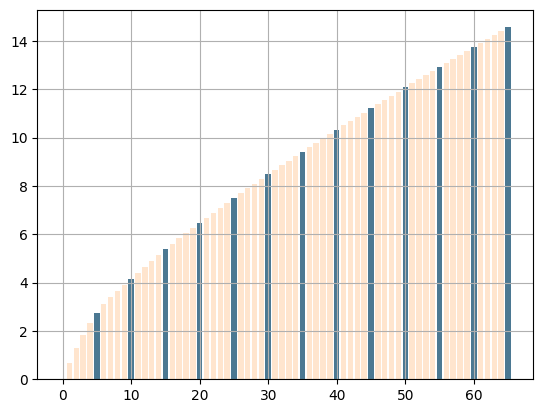

In [113]:
N = 14
x_data = [5*i for i in range(N)]
y_data = [x**(1/2) + 0.1*x for x in x_data]
plt.bar(x_data, y_data)
plt.grid(True)

age_max = 100
age_step = 5
x_interp = [i for i in range(age_max)]
y_interp = [np.NaN for i in range(len(x_interp))]

y_data_index = 0
for i in range(len(x_interp)):
    if i%age_step == 0 and y_data_index < len(y_data):
        y_interp[i] = y_data[y_data_index]
        y_data_index+=1
y_interp = pd.Series(y_interp)
y_interp = y_interp.interpolate(method='polynomial', order=2)
plt.bar(x_interp, y_interp, alpha=0.2)
